# Generating data

This notebook explains how to generate data that can be used for training and evaluation the end-to-end model of the master's thesis “Wave propagation aided by Deep Learning” by Luis Kaiser, supervised by Prof. Tsai (University of Texas Austin) and Prof. Klingenberg (University of Wuerzburg), in practice. More information about the algorithm can be found in my [code](https://github.com/utkaiser/masterthesis_code) or [writeup](https://github.com/utkaiser/masterthesis_writing). Parts of this code are extracted from the files `generate_data/generate_velocity_crop.py` and `generate_data/datagen_end_to_end.py`.

First, make sure that you have install all necessary libraries specified in `requirements.txt` using `pip` or `pip3` depending on your setup by running the command below.

In [ ]:
!pip3 install --upgrade pip
!pip3 install -r requirements.txt

We first generate the random velocity profile crops from `../data/velocity_profiles/marm1nonsmooth.mat` and `../data/velocity_profiles/bp2004.mat` and save the results in an `.npz` file.

In [6]:
from skimage.filters import gaussian
from scipy.io import loadmat
from generate_data.generate_velocity_crop import createCropsAndSave

def generate_velocity_crops(
        resolution = 256,
        output_dir = 'crop_test.npz',
        num_crops = 1,
):
    '''

    Parameters
    ----------
    resolution : (int) resolution of crop
    output_dir : (string) output file path, ending with ".npz"
    num_crops :  (int) number of crops per image

    Returns
    -------
    saves the velocity crops in an .npz-file
    '''

    # load images
    datamat = loadmat('../data/velocity_profiles/marm1nonsmooth.mat')  # Marmousi velocity image
    fullmarm = gaussian(datamat['marm1larg'],4)  # smoothing the image
    databp = loadmat('../data/velocity_profiles/bp2004.mat')  # BP velocity image
    fullbp = gaussian(databp['V'],4)/1000  # smoothing the image and different order of magnitude

    # randomly crop and save images at "output_dir"
    createCropsAndSave(
        v_images = [fullmarm,fullbp],
        m = resolution,
        outputdir = output_dir,
        num_times = num_crops)


generate_velocity_crops()

img 0
--- 0
img 1
--- 0


We then use numerical solvers shown in `use_numerical_solvers.ipynb` to advance a wave field on these velocity profiles. The data is stored in a `.npz` file and can later be used for training and evaluation the models. Note that the design of the function `generate_wave_from_medium` is not optimal for this purpose since it was used and changed for different applications. However, this should provide you with the basic workflow on how to generate data.

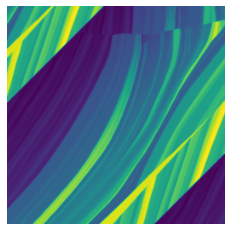

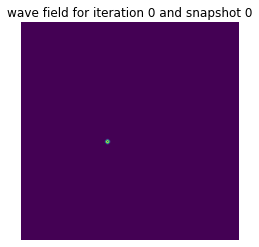

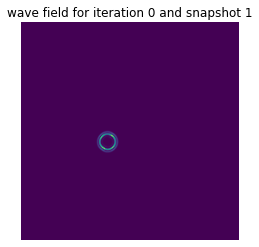

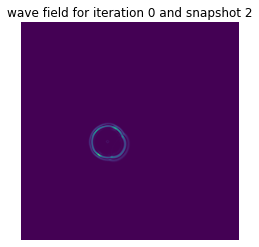

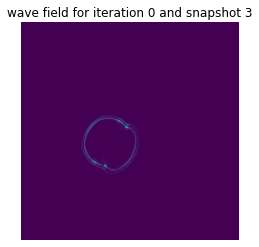

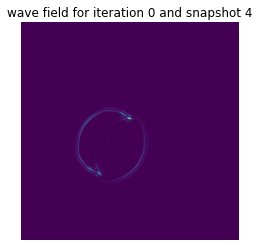

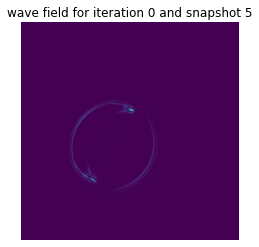

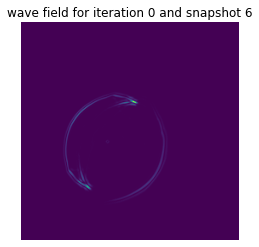

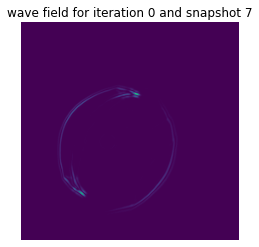

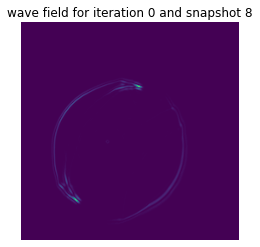

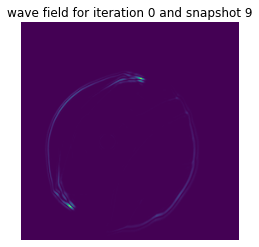

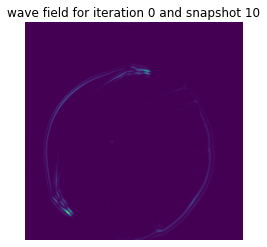

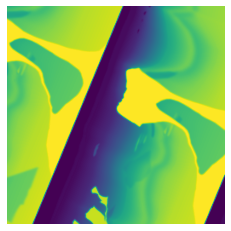

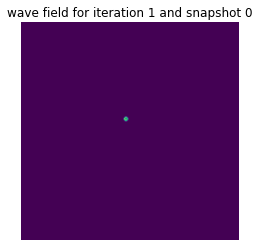

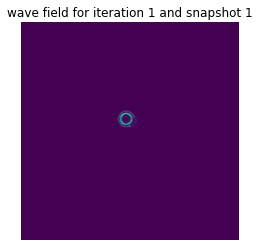

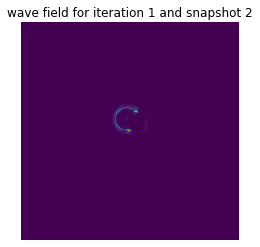

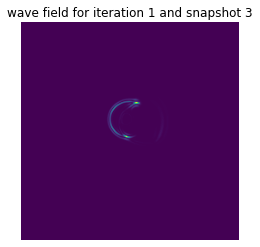

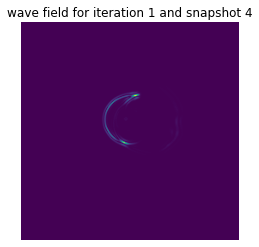

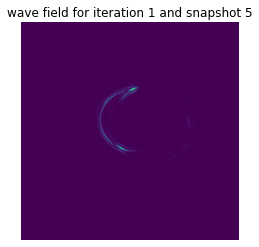

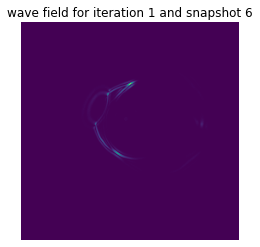

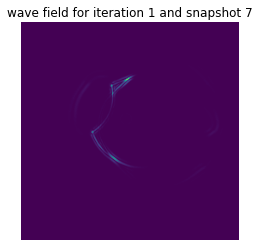

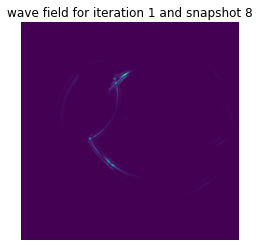

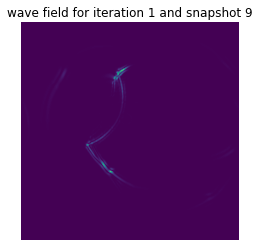

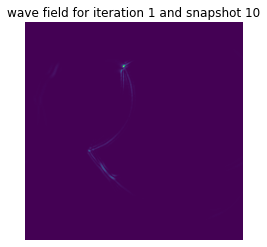

In [14]:
from matplotlib import pyplot as plt
import numpy as np
from generate_data.initial_conditions import initial_condition_gaussian
import torch
from generate_data.utils import crop_center
from generate_data.change_wave_arguments import  WaveSol_from_EnergyComponent_tensor, WaveEnergyComponentField_end_to_end,WaveEnergyField
from generate_data.utils_wave_propagate import one_iteration_pseudo_spectral_tensor, one_iteration_velocity_verlet


def visualize_wavefield(
        u_elapse,
        ut_elapse,
        vel,
        f_delta_x,
        it,
        s
):
    '''
    Parameters
    ----------
    u_elapse : (numpy tensor) wave field component u
    ut_elapse : (numpy tensor) wave field component u derived by t, i.e. the velocity
    vel : (numpy tensor) velocity profile image
    f_delta_x : (float) grid time stepping of solver
    it : (int) number of current iteration
    s : (int) number of current snapshot

    Returns
    -------
    visualizes current wave field iteration
    '''

    # change representation to energy semi-norm
    w = WaveEnergyField(u_elapse.squeeze().numpy(),ut_elapse.squeeze().numpy(),vel, f_delta_x)

    # visualize results
    plt.axis("off")
    plt.imshow(w)
    plt.title(f"wave field for iteration {it} and snapshot {s}")
    plt.show()


def generate_data_end_to_end(
        input_path = "crop_test.npz",
        output_path = "datagen_test.npz",
        boundary_condition = "periodic",
        n_snaps = 10,
        res = 256,
        n_it = 2,
        f_delta_x =  2. / 256.
):
    '''
    Parameters
    ----------
    input_path : (string) velocity profile data path
    output_path: (string) wave field data path
    boundary_condition : (string) boundary condition, either "periodic" or "absorbing"
    n_snaps : (int) amount of snapshots / dt_star steps to take
    res : (int) resolution of wave field output
    n_it : (int) amount of different wave propagation series
    f_delta_x : (float) grid time stepping of solver

    Returns
    -------
    saves generated wave propagation iterations in file
    '''

    # load velocity model created in function above `generate_velocity_crops()`
    velocities = np.load(input_path)['wavespeedlist']

    # setup tensors to store wave energy components and velocity profile
    # save image for each iteration and snapshot
    Ux, Uy, Utc = np.zeros([n_it, n_snaps + 1, res, res]), \
                  np.zeros([n_it, n_snaps + 1, res, res]), \
                  np.zeros([n_it, n_snaps + 1, res, res])
    V = np.zeros([n_it, n_snaps+1, res, res])

    # training
    for it in range(n_it):

        # sample velocity instance
        vel = velocities[it]  # w_big x h_big

        # computing initial condition using gaussian pulse (switch to pytorch tensor if needed)
        # note that this will contain the energy components,
        # i.e. u_energy[b][0,...,2] relates to the partial derivatives mentioned in the thesis, while b denotes the batch
        u_energy = initial_condition_gaussian(
            torch.from_numpy(vel),
            resolution=res,
            boundary_condition="periodic",
            mode="other",
            res_padded=res,
            optimization = "none",
        )

        # create and save velocity crop
        vel_crop = crop_center(vel, res, boundary_condition)  # crop center of the image if boundary condition == "absorbing"
        V[it] = np.repeat(vel_crop[np.newaxis, :, :], n_snaps + 1, axis=0)  # save velocity image (n_snaps + 1) times in V

        # visualize velocity profile used for iterations
        plt.axis("off")
        plt.imshow(vel_crop)
        plt.show()
        plt.title(f"velocity profile for iteration {it}")

        # integrate dt_star (step size) n_snaps times
        for s in range(n_snaps+1):

            # change energy components to wave field representation
            u_elapse, ut_elapse = WaveSol_from_EnergyComponent_tensor(
                u_energy[:,0],
                u_energy[:,1],
                u_energy[:,2],
                torch.from_numpy(vel),
                f_delta_x,
                torch.sum(torch.sum(torch.sum(u_energy[:,0])))
            )

            visualize_wavefield(
                u_elapse,
                ut_elapse,
                vel,
                f_delta_x,
                it,
                s
            )

            if boundary_condition == "absorbing":

                # cropping and save current snapshot in tensors
                u_elapse_crop, ut_elapse_crop = crop_center(u_elapse, res), crop_center(ut_elapse, res)
                Ux[it, s], Uy[it, s], Utc[it, s] = \
                    WaveEnergyComponentField_end_to_end(u_elapse_crop, ut_elapse_crop, vel_crop, f_delta_x)

            else:
                # save current snapshot in tensors
                Ux[it, s], Uy[it, s], Utc[it, s] = u_energy[0,0], u_energy[0,1], u_energy[0,2]

            # itegration step (done for all iterations only not for last one)
            if s < n_snaps + 1:
                # apply pseudo spectral solver (alternatively the velocity verlet solver)
                u_energy = one_iteration_pseudo_spectral_tensor(
                    torch.cat([u_energy, torch.from_numpy(vel).unsqueeze(dim=0).unsqueeze(dim=0)], dim=1))

    # save tensors in file, accessible through key-value queries
    np.savez(output_path, vel=V, Ux=Ux, Uy=Uy, Utc=Utc)


generate_data_end_to_end()